In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from monai.transforms import (
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    Resized,
    SpatialPadd,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    ToTensord,
)

In [2]:
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))
print(os.getcwd())

/home/AR32500/AR32500/MyPapers/box-prompt-learning-VFM/src


In [3]:
from Utils.utils import natural_keys

## Functions for preprocessing

In [4]:
def get_val_patient_idx(train_patient_idx=[], num_val_patients=10):
    print('Creating a validation dataset with {} patients'.format(num_val_patients))
    _val_patient_idx = random.sample(train_patient_idx, num_val_patients)
    val_patient_idx = sorted(_val_patient_idx)
    return val_patient_idx


def get_train_test_patient_idx(data_dir, images_list, num_test_patients):
    """_summary_

    Args:
        data_dir (str): data directory
        images_list (list): list of paths to each images (ending with .nii.gz)
        num_test_patients (int, optional): number of test patients. Defaults to 10.

    Returns:
        train_patient_idx (list)
        test_patient_idx (list)
    """        
    # We choose test patients
    patient_name_list = [os.path.basename(path).replace('.nii.gz', '') for path in images_list]
    _test_patient_idx = random.sample(patient_name_list, num_test_patients)
    test_patient_idx = sorted(_test_patient_idx)

    train_patient_idx = [name for name in patient_name_list if name not in test_patient_idx]
        
    return train_patient_idx, test_patient_idx
    
    
def get_train_val_test_list(data_dir, images_list, num_test_patients, num_val_patients):    
    _train_patient_idx, test_patient_idx = get_train_test_patient_idx(data_dir, images_list, num_test_patients)
    val_patient_idx = get_val_patient_idx(_train_patient_idx, num_val_patients)
    
    assert all(value in _train_patient_idx for value in val_patient_idx)
    train_patient_idx = [idx for idx in _train_patient_idx if idx not in val_patient_idx]
    
    print('train patients:', len(list(train_patient_idx)))
    print('val patients:', len(list(val_patient_idx)))
    print('test patients:', len(list(test_patient_idx)))
    
    return train_patient_idx, val_patient_idx, test_patient_idx

In [5]:
def create_sam_directories(base_dir, type='slice'):
    """Create directories"""
    dir_paths = {}
    if type == 'slice':
        for dataset in ['train', 'val', 'test']:
            for data_type in ['2d_images', '2d_masks']:
                # Construct the directory path
                dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
                dir_paths[f'{dataset}_{data_type}'] = dir_path
                # Create the directory
                os.makedirs(dir_path, exist_ok=True)
    elif type == 'volume':
        for dataset in ["imagesTr", "labelsTr"]:
            # Construct the directory path
            dir_path = os.path.join(base_dir, dataset)
            dir_paths[dataset] = dir_path
            # Create the directory
            os.makedirs(dir_path, exist_ok=True)        
    return dir_paths

def ceil_to_multiple_of_5(n):
    return 5 * np.ceil(n / 5.)

def read_patient_info_data(data_dir, dataset_name, folder_name, patient_name):
    """
    Reads patient data in the cfg file from patient folder 
    using Info.cfg
    """
    patient_data = {}

    info_filepath = os.path.join(data_dir, dataset_name, folder_name, patient_name, 'Info.cfg')
    with open(info_filepath) as f_in:
        for line in f_in:
          l = line.rstrip().split(": ")
          patient_data[l[0]] = l[1]
    return patient_data

# Preprocessing dataset

In [6]:
data_dir = '/home/AR32500/net/data' # To change
dataset_name = 'ACDC'
file_type = 'ED'

remove_background_slices = True
minimum_foreground_size = True
class_list = [1, 2, 3]

# Resizing parameters
crop_pad_size = (256, 256)
new_size = (256, 256)

In [7]:
data_type = 'training' # Change to training or testing

In [8]:
folder_name = os.path.join('raw', data_type)

if data_type == 'training':
    frac_test_patients = 0
    frac_val_patients = 0.1
if data_type == 'testing':
    frac_test_patients = 1
    frac_val_patients = 0


In [9]:
os.path.join(data_dir, dataset_name)

'/home/AR32500/net/data/ACDC'

In [10]:
# We create create 6 folders in the subfolder 'preprocessed_sam' of the directory associated with the dataset: 
# 2 folders ('2d_images' and '2d_masks') for each cut ['train', 'val', 'test'].
raw_data_dir = os.path.join(data_dir, dataset_name, folder_name)
base_dir_slice = os.path.join(data_dir, dataset_name, 'preprocessed_sam')

patient_name_list = [f for f in os.listdir(os.path.join(data_dir, dataset_name, folder_name)) if (not f.startswith('.') and not f.endswith('.md'))]
patient_name_list.sort(key=natural_keys)
print(len(patient_name_list))

# We get train, val and test patient names
num_test_patients = int(ceil_to_multiple_of_5(len(patient_name_list) * frac_test_patients))
num_val_patients = int(len(patient_name_list) * frac_val_patients)
train_patient_idx, val_patient_idx, test_patient_idx = get_train_val_test_list(raw_data_dir, patient_name_list, num_test_patients, num_val_patients)

# Create directories to save preprocessed volumes and slices
dir_paths_slice = create_sam_directories(base_dir_slice, type="slice")

100
Creating a validation dataset with 10 patients
train patients: 90
val patients: 10
test patients: 0


In [11]:
print(dir_paths_slice)

{'train_2d_images': '/home/AR32500/net/data/ACDC/preprocessed_sam/train_2d_images', 'train_2d_masks': '/home/AR32500/net/data/ACDC/preprocessed_sam/train_2d_masks', 'val_2d_images': '/home/AR32500/net/data/ACDC/preprocessed_sam/val_2d_images', 'val_2d_masks': '/home/AR32500/net/data/ACDC/preprocessed_sam/val_2d_masks', 'test_2d_images': '/home/AR32500/net/data/ACDC/preprocessed_sam/test_2d_images', 'test_2d_masks': '/home/AR32500/net/data/ACDC/preprocessed_sam/test_2d_masks'}


In [13]:
# val_patient_idx = ['patient012', 'patient022', 'patient049', 'patient052', 'patient057', 'patient058', 'patient059', 'patient073', 'patient096', 'patient100']
# train_patient_idx = [file for file in patient_name_list if file not in val_patient_idx]
# print(len(train_patient_idx))

90


In [14]:
# Transformations to apply on the 3D volume
volume_transforms = Compose([
    LoadImaged(keys=["img", "label"]),
    ScaleIntensityRangePercentilesd(keys=["img"], lower=0.5, upper=99.5, b_min=0, b_max=255, clip=True),
])

# Transformations to apply on the 2D slices
slice_transforms = Compose([
    Spacingd(keys=['img', 'label'], pixdim=(1, 1), mode=("bilinear", "nearest")),
    CenterSpatialCropd(keys=['img', 'label'], roi_size=crop_pad_size),
    SpatialPadd(keys=["img", "label"], spatial_size=crop_pad_size),
    Resized(keys=["img", "label"], spatial_size=new_size, mode=['bilinear', 'nearest']),
    ToTensord(keys=["img", "label"])
])

patient001 torch.Size([216, 256, 10])
not all label classes: 0
1
2
3
4
5
6
7
8
9
patient002 torch.Size([232, 256, 10])
0
1
2
3
4
5
6
7
not all label classes: 8
not all label classes: 9
patient003 torch.Size([256, 256, 10])
not all label classes: 0
1
2
3
4
5
6
7
8
not all label classes: 9
patient004 torch.Size([232, 256, 10])
0
1
2
3
4
5
6
7
not all label classes: 8
not all label classes: 9
patient005 torch.Size([256, 216, 10])
not all label classes: 0
1
2
3
4
5
6
7
8
9


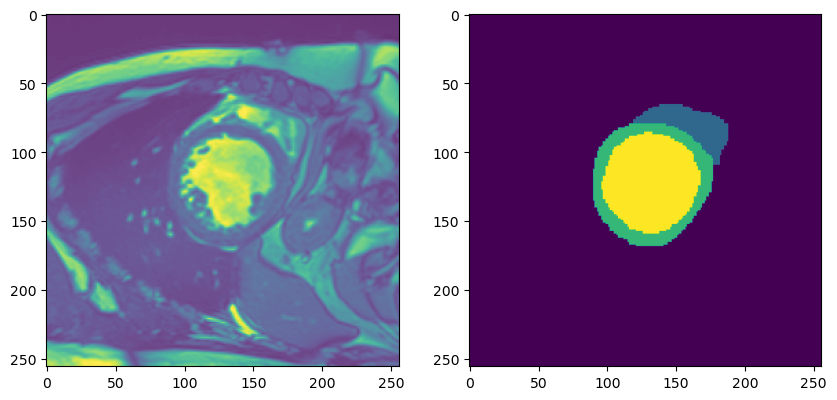

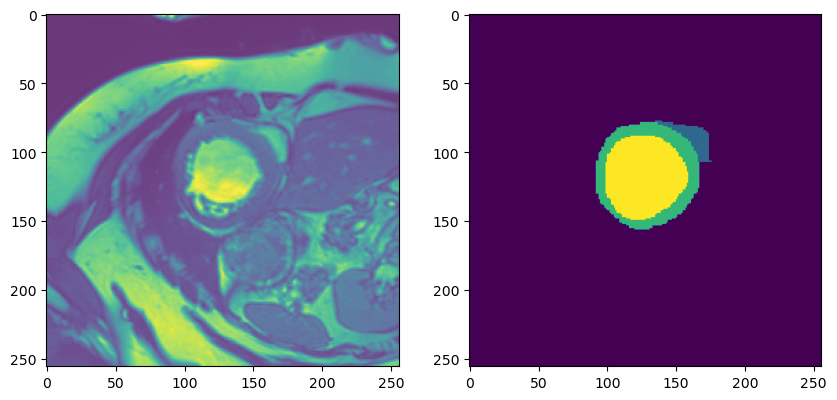

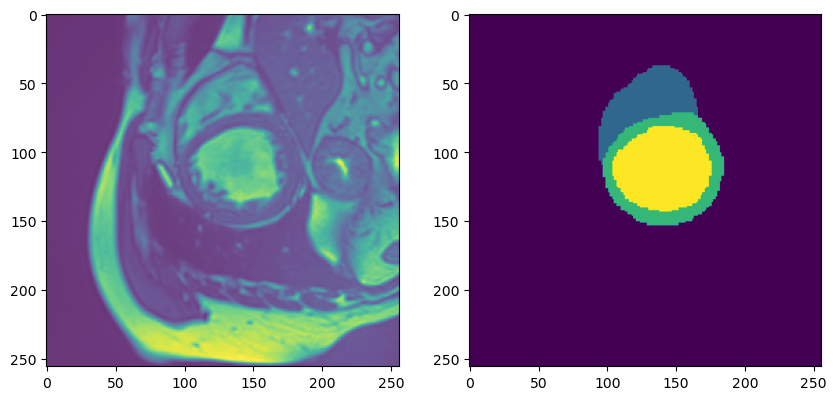

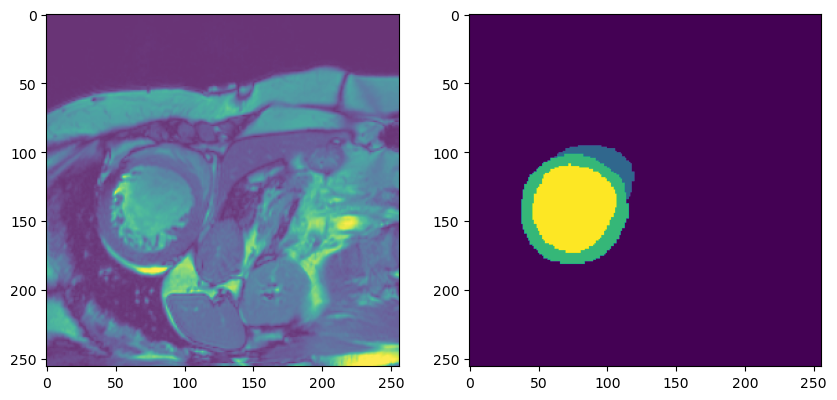

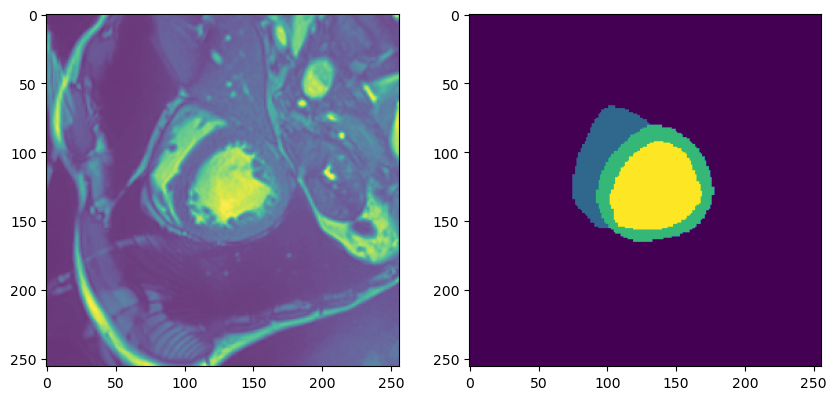

In [15]:
for patient_name in patient_name_list:
    
    patient_data = read_patient_info_data(data_dir, dataset_name, 'raw' + '/' + str(data_type), patient_name)
    # Get volume and GT from frame number
    frame_No = int(patient_data[file_type])
    
    img_path = os.path.join(data_dir, dataset_name, folder_name, patient_name, 
                            '{}_frame{:02}.nii.gz'.format(patient_name, frame_No))
    mask_path = os.path.join(data_dir, dataset_name, folder_name, patient_name, 
                             '{}_frame{:02}_gt.nii.gz'.format(patient_name, frame_No))

    volume_data = volume_transforms({'img': img_path, 'label': mask_path})
    
    print(patient_name, volume_data['img'].shape)

    # Process each slice individually
    imgs_2d, masks_2d = [], []
    for i in range(volume_data['img'].shape[-1]):  # Assuming channel first format
        img_slice = volume_data['img'][:, :, i].unsqueeze(0)  # Add channel dimension
        mask_slice = volume_data['label'][:, :, i].unsqueeze(0)  # Add channel dimension

        slice_data = {'img': img_slice, 'label': mask_slice}

        # Apply slice transformations
        transformed_slice = slice_transforms(slice_data)
        img_2d = transformed_slice['img'].squeeze().astype(np.uint8)  # Remove channel dimension for 2D processing
        mask_2d = transformed_slice['label'].squeeze().astype(np.uint8) # Remove channel dimension

        unique, counts = np.unique(mask_2d, return_counts=True)
        # Check if there are at least 4 pixels of each class
        min_pixels_per_class = 10
        
        # Optionally remove non-informative slices
        #if remove_background_slices and np.all(mask_2d == 0):
        unique_labels = np.unique(mask_2d)
        if remove_background_slices and not all(label in unique_labels for label in class_list):
            print('not all label classes: {}'.format(i))
            pass
            
        elif minimum_foreground_size and(not all(count >= min_pixels_per_class for count in counts)):
            print('minimum_foreground_size: {}'.format(i))
            pass
            
        else:
            print(i)
            
            # Select appropriate directories
            if patient_name in train_patient_idx:  # Training
                img_dir = dir_paths_slice['train_2d_images']
                mask_dir = dir_paths_slice['train_2d_masks']
            elif patient_name in val_patient_idx:  # Validation
                img_dir = dir_paths_slice['val_2d_images']
                mask_dir = dir_paths_slice['val_2d_masks']
            else:  # Testing
                img_dir = dir_paths_slice['test_2d_images']
                mask_dir = dir_paths_slice['test_2d_masks']

            # Define the output paths
            img_slice_path = os.path.join(img_dir, os.path.basename(img_path).replace('.nii.gz', '_slice{}.nii.gz'.format(i)))
            mask_slice_path = os.path.join(mask_dir, os.path.basename(mask_path).replace('_gt.nii.gz', '_slice{}.nii.gz'.format(i)))

            sitk.WriteImage(sitk.GetImageFromArray(img_2d), img_slice_path)
            sitk.WriteImage(sitk.GetImageFromArray(mask_2d), mask_slice_path)

            # Plot
            if i == volume_data['img'].shape[-1] //2:
                fig = plt.figure(figsize=(10, 10))
                ax = fig.add_subplot(121)
                ax.imshow(img_2d, alpha=0.8)
                ax = fig.add_subplot(122)
                ax.imshow(mask_2d)